In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)

In [ ]:
##load the dataset


In [2]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [103]:
# Load images into arrays
import pathlib

#specify a maximum how many pair that can be made pr class (value is for both positive and negative pairs )

def load_images(path):
    img_array_data = []
    data_dir = pathlib.Path(path)
    image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
    folders = [x for x in data_dir.iterdir() if x.is_dir()]
    for i, folder in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(folder.iterdir()):
        
            img_array_data[i].append(img)
            
    return img_array_data


def load_images_v2(path):
    data_dir = os.listdir(path)
    img_array_data = []
    
    folders = data_dir#[x for x in data_dir]
    for i, dir_path in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(os.listdir(path + "/"+dir_path)):
        
            img_array_data[i].append(path + "/"+dir_path+"/"+img)
            
    return img_array_data





#test_data = load_images("./data/tiered_imagenet/test")

#val_data = load_images("./data/tiered_imagenet/val")


def get_anchor_and_positives(images, max_pairs, max_pairs_per_class):
    anchor_images, positive_images = [],  []
    should_break = False
    should_terminate = False
    
    for i, array in enumerate(images):
        if(should_terminate):
            print("Terminating with a class count of: ", i-1)
            break
        for j in range(len(array)-1):
            if(should_break):
                should_break = False
                break
            
            for k in range(len(array)-1):
            
                
                
               
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                if(len(anchor_images) >= max_pairs): 
                    print("Terminating with a pair count of: ", (i+1)*(j+1)*(k+1))
                    should_terminate = True
                    should_break = True
                    break
                if((j+1)*(k+1) >= max_pairs_per_class):
                    should_break = True
                    break
                
                
                
                
    if(not should_terminate):
        print("Terminating with a class count of: ", str(len(images)))         
    return anchor_images, positive_images


#anchor_images, positive_images = get_anchor_n_positives(test_data)
#anchor_images, positive_images = get_anchor_n_positives(val_data)



#print("train samples: ", len(train_data))
#print("validation samples: ",len(val_data))
#print("test samples: ", len(test_data))

#unison_shuffled_copies(train_data, train_labels)
#unison_shuffled_copies(test_data, test_labels)
#unison_shuffled_copies(val_data, val_labels)

In [109]:

data = []
data.extend(load_images_v2("./data/tiered_imagenet/train"))
data.extend(load_images_v2("./data/tiered_imagenet/val"))
data.extend(load_images_v2("./data/tiered_imagenet/test"))
print("Maximum Available Classes: " + str(len(data)))
anchor_images, positive_images = get_anchor_and_positives(data, 3000, 5)
pair_count = len(anchor_images)
print(pair_count)




Maximum Available Classes: 608
Terminating with a pair count of:  3000
Terminating with a class count of:  599
3000


In [111]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(pair_count * 0.8))
val_dataset = dataset.skip(round(pair_ount * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

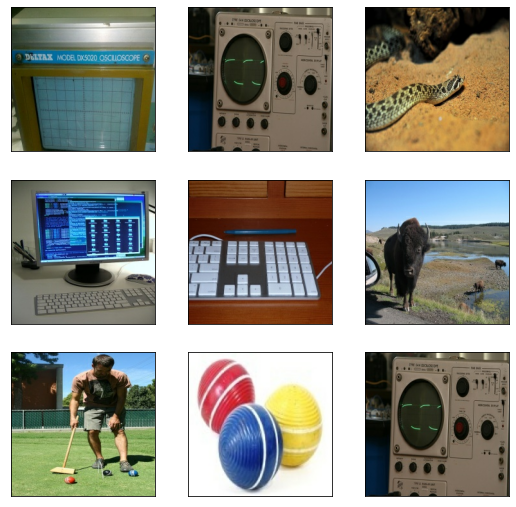

In [23]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])